In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install opencv-python
!pip install scikit-video


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#le dataset UCF101
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
! unrar x UCF101.rar
import os
dataset_path = "/content/UCF-101/"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Ex

In [ ]:
categories = os.listdir (dataset_path)
print("Nombre de catégories:", len (categories))
print("Quelques catégories:", categories [:20])

Nombre de catégories: 101
Quelques catégories: ['BasketballDunk', 'RockClimbingIndoor', 'RopeClimbing', 'WritingOnBoard', 'Lunges', 'CricketShot', 'Punch', 'HeadMassage', 'SoccerPenalty', 'CuttingInKitchen', 'BandMarching', 'JumpRope', 'ParallelBars', 'Knitting', 'PlayingGuitar', 'BoxingPunchingBag', 'Rowing', 'Drumming', 'WalkingWithDog', 'ShavingBeard']


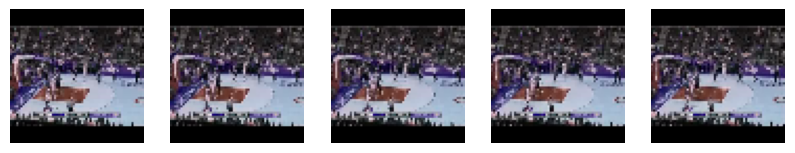

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_video(video_path, max_frames=40, resize=(64, 64)):
  cap = cv2.VideoCapture(video_path)
  frames = []
  count = 0
  while True:
    ret, frame = cap.read()
    if not ret or count >= max_frames:
      break
    frame = cv2.resize(frame, resize)
    frames.append(frame)
    count += 1
  cap.release()
  return np.array(frames)

video_example = os.path.join(dataset_path, categories[0], os.listdir(os.path.join(dataset_path, categories[0]))[10])

video_frames = load_video(video_example)

plt.figure(figsize=(10, 5))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(video_frames[i])
  plt.axis('off')
plt.show()

In [ ]:
#how many frames a video has

import cv2

def get_frame_count(video_path):
  cap = cv2.VideoCapture(video_path)
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap.release()
  return frame_count

video_example = os.path.join(dataset_path, categories[0], os.listdir(os.path.join(dataset_path, categories[0]))[10])
frame_count = get_frame_count(video_example)
print(f"The video has {frame_count} frames.")

The video has 89 frames.


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from keras.optimizers import Adam
def prepare_data(num_samples_per_class=len(categories)):
  X, y = [], []
  for category_idx, category in enumerate (categories [:10]):
    video_files =os.listdir(os.path.join(dataset_path, category)) [:num_samples_per_class]
    for video_file in video_files:
      video_path= os.path.join(dataset_path, category, video_file)
      frames =load_video(video_path)
      if frames.shape[0] == 40:
        X.append(frames)
        y.append(category_idx)
  X= np.array (X)
  y=to_categorical (np.array(y), num_classes=len(categories[:10]))
  return X, y
X, y =prepare_data()
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

def build_cnn(input_shape, num_classes = 20):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
  model.add(TimeDistributed(MaxPooling2D(2, 2)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding ='same')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(128, return_sequences=False))
  model.add(Dropout(0.5))


  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


input_shape = (40, 64, 64, 3)
num_classes = len(categories[:10])

model = build_cnn(input_shape, num_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=35, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_10                  │ (None, 40, 64, 64, 32)      │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 40, 32, 32, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 40, 32, 32, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 40, 16, 16, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 40, 16384)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │       8,454,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,491,850 (32.39 MB)

 Trainable params: 8,491,850 (32.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

print("Training data size:", len(X_train))
print("Testing data size:", len(X_val))

Training data size: 806
Testing data size: 202


In [ ]:

print("Training data size:", len(X_train))
print("Testing data size:", len(X_val))

In [ ]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=8,callbacks=[early_stopping,reduce_lr])

Epoch 1/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.1283 - loss: 2.2998 - val_accuracy: 0.0693 - val_loss: 2.3090 - learning_rate: 4.0000e-05
Epoch 2/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 53s 196ms/step - accuracy: 0.1170 - loss: 2.3022 - val_accuracy: 0.0693 - val_loss: 2.3090 - learning_rate: 4.0000e-05
Epoch 3/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.0956 - loss: 2.3107 - val_accuracy: 0.0693 - val_loss: 2.3091 - learning_rate: 4.0000e-05
Epoch 4/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.1256 - loss: 2.3019 - val_accuracy: 0.0693 - val_loss: 2.3091 - learning_rate: 4.0000e-05
Epoch 5/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.0958 - loss: 2.3049 - val_accuracy: 0.0693 - val_loss: 2.3091 - learning_rate: 4.0000e-05
Epoch 6/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.1057 - loss: 2.3040
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-05.
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accurac

In [ ]:
# prompt: evluate the model on test data

loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# prompt: plot accracy and loss graph for training and test data

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()